In [2]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/vgg/tensorflow2/default/1/best_model_scratch.keras")   

I0000 00:00:1764480895.544763      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


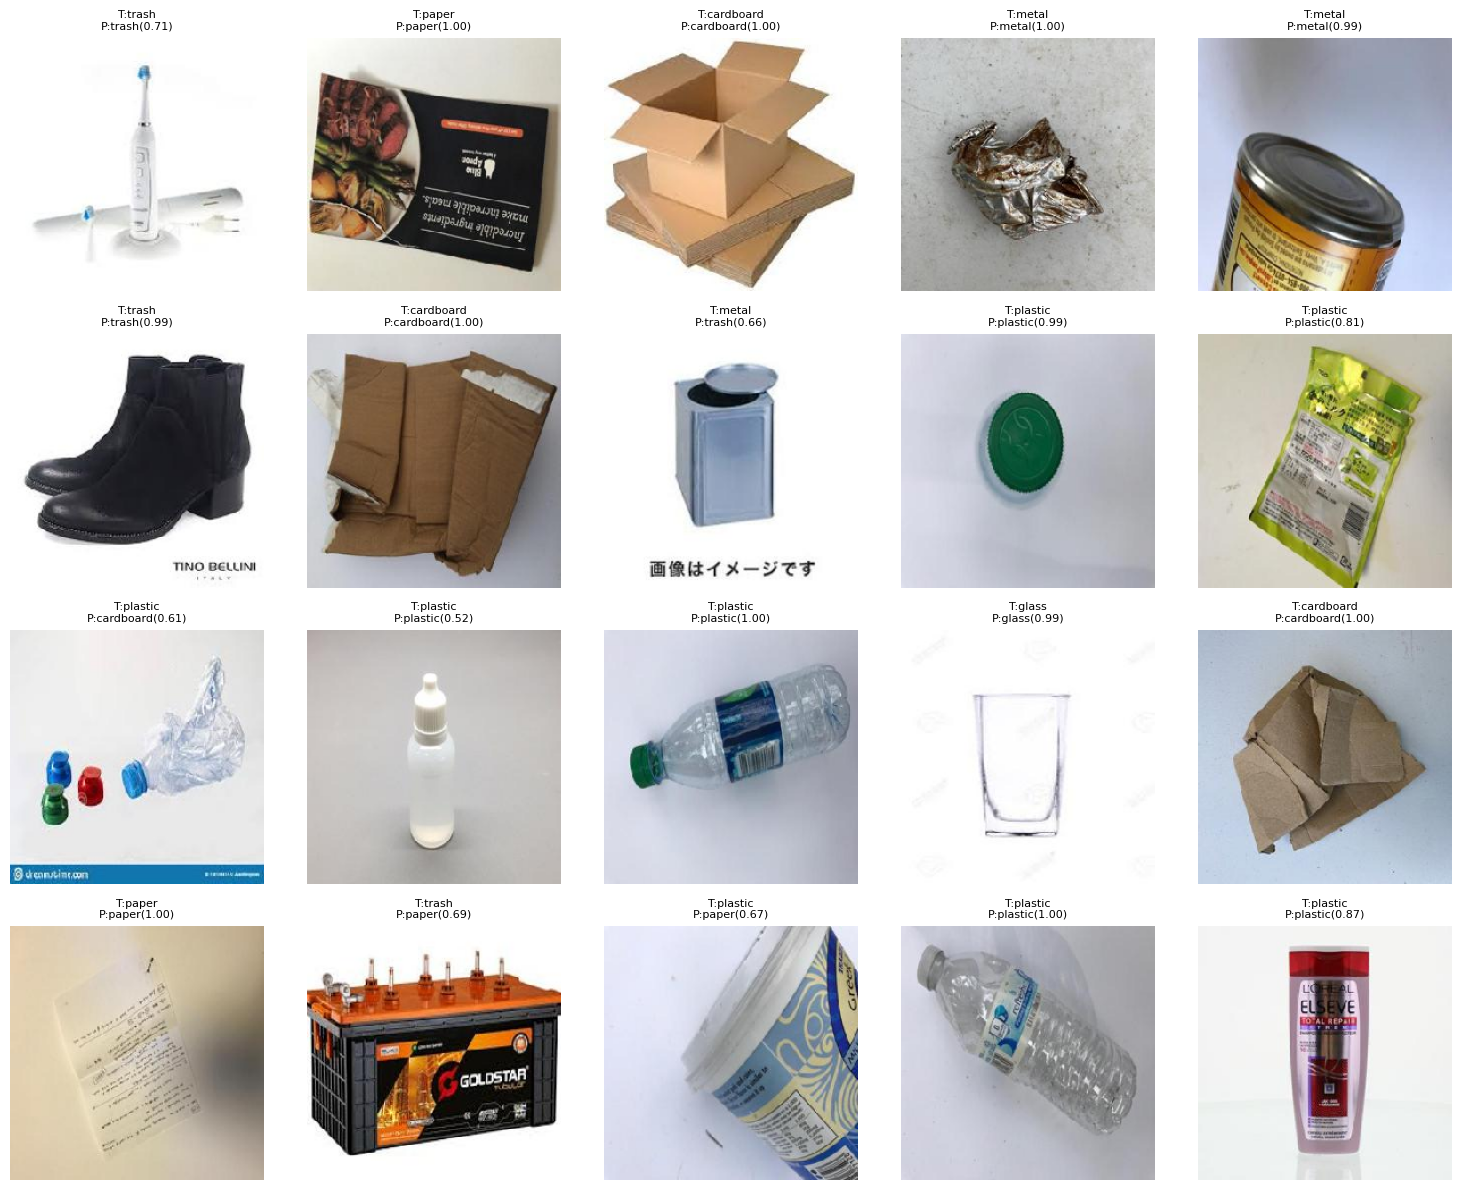

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# =========================
# 1. Load model
# =========================
model = load_model("/kaggle/input/vgg/tensorflow2/default/1/best_model_scratch.keras")

class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Dataset đúng
data_dir = "/kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images"

# =========================
# Hàm lấy ảnh ngẫu nhiên
# =========================
def get_random_image(data_dir):
    categories = [c for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, c))]
    random_class = random.choice(categories)
    class_path = os.path.join(data_dir, random_class)

    files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random_img = random.choice(files)
    img_path = os.path.join(class_path, random_img)
    
    return img_path, random_class

# =========================
# Hàm dự đoán
# =========================
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)

    preds = model.predict(img_array)
    class_id = np.argmax(preds)
    
    return class_names[class_id], preds[0][class_id], img

# =========================
# Vẽ grid 20 ảnh
# =========================
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(20):
    img_path, true_label = get_random_image(data_dir)
    pred_label, confidence, img = predict_image(img_path)

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"T:{true_label}\nP:{pred_label}({confidence:.2f})", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


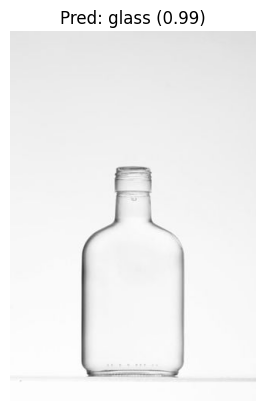

In [22]:
import requests
from PIL import Image
import io

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content)).convert("RGB")
    return img
def predict_image_url(url):
    img = load_image_from_url(url)
    img_resized = img.resize((224, 224))

    img_array = image.img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, 0)

    preds = model.predict(img_array)
    class_id = np.argmax(preds)

    return class_names[class_id], preds[0][class_id], img
url = "https://product.hstatic.net/1000236664/product/chai-thuy-tinh-dep-175ml-2_large.jpg"
pred_label, confidence, img = predict_image_url(url)

plt.imshow(img)
plt.title(f"Pred: {pred_label} ({confidence:.2f})")
plt.axis("off")
plt.show()


In [27]:
import os, random, warnings, json, shutil, math
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, 
    BatchNormalization, Add, Activation, ZeroPadding2D, Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Paths and Parameters
data_path = '/kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images'
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
out_dir_resnet = f'/kaggle/working/garbage_resnet50_scratch_run_{timestamp}'
os.makedirs(out_dir_resnet, exist_ok=True)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 200  # More epochs for from-scratch training
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15

# Dataset Splitting
train_dir = os.path.join(out_dir_resnet, 'train')
valid_dir = os.path.join(out_dir_resnet, 'valid')
test_dir = os.path.join(out_dir_resnet, 'test')

for d in [train_dir, valid_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

print("Splitting dataset...")
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if not os.path.isdir(class_path):
        continue
    
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)
    total = len(images)
    
    train_end = int(total * train_ratio)
    valid_end = int(total * (train_ratio + valid_ratio))
    
    split_sets = {
        train_dir: images[:train_end],
        valid_dir: images[train_end:valid_end],
        test_dir: images[valid_end:]
    }
    
    for folder, img_list in split_sets.items():
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)
        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(folder, class_name, img)
            if not os.path.exists(dst):
                shutil.copy(src, dst)
    
    print(f"  {class_name}: {len(split_sets[train_dir])} train, "
          f"{len(split_sets[valid_dir])} valid, {len(split_sets[test_dir])} test")

print("✅ Dataset split complete.\n")

Splitting dataset...
  metal: 1458 train, 313 valid, 313 test
  glass: 1750 train, 375 valid, 375 test
  paper: 1620 train, 347 valid, 348 test
  trash: 1750 train, 375 valid, 375 test
  cardboard: 1549 train, 332 valid, 333 test
  plastic: 1601 train, 343 valid, 344 test
✅ Dataset split complete.



In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    channel_shift_range=30
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

print(f"Classes ({classes}): {class_labels}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {valid_generator.samples}")
print(f"Test samples: {test_generator.samples}\n")

# GPU Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0]}\n")
    except RuntimeError as e:
        print(e)

steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(valid_generator.samples / BATCH_SIZE)

Found 9728 images belonging to 6 classes.
Found 2085 images belonging to 6 classes.
Found 2088 images belonging to 6 classes.
Classes (6): ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Training samples: 9728
Validation samples: 2085
Test samples: 2088

Physical devices cannot be modified after being initialized


In [29]:

def identity_block(x, filters):
    """
    Identity block for ResNet (no dimension change)
    filters: list of 3 integers, the number of filters in the 3 conv layers
    """
    f1, f2, f3 = filters
    
    # Save input for skip connection
    x_shortcut = x
    
    # First component
    x = Conv2D(f1, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second component
    x = Conv2D(f2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third component
    x = Conv2D(f3, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add skip connection
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

def convolutional_block(x, filters, stride=2):
    """
    Convolutional block for ResNet (with dimension change)
    filters: list of 3 integers, the number of filters in the 3 conv layers
    stride: stride for the first conv layer
    """
    f1, f2, f3 = filters
    
    # Save input for skip connection
    x_shortcut = x
    
    # First component
    x = Conv2D(f1, (1, 1), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second component
    x = Conv2D(f2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third component
    x = Conv2D(f3, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Shortcut path
    x_shortcut = Conv2D(f3, (1, 1), strides=stride, padding='same')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    # Add skip connection
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

def ResNet50(input_shape=(224, 224, 3), num_classes=10):
    """
    Build ResNet-50 architecture from scratch
    """
    # Input layer
    X_input = Input(input_shape)
    
    # Zero-padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, filters=[64, 64, 256], stride=1)
    X = identity_block(X, filters=[64, 64, 256])
    X = identity_block(X, filters=[64, 64, 256])
    
    # Stage 3
    X = convolutional_block(X, filters=[128, 128, 512], stride=2)
    X = identity_block(X, filters=[128, 128, 512])
    X = identity_block(X, filters=[128, 128, 512])
    X = identity_block(X, filters=[128, 128, 512])
    
    # Stage 4
    X = convolutional_block(X, filters=[256, 256, 1024], stride=2)
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    
    # Stage 5
    X = convolutional_block(X, filters=[512, 512, 2048], stride=2)
    X = identity_block(X, filters=[512, 512, 2048])
    X = identity_block(X, filters=[512, 512, 2048])
    
    # Average Pooling
    X = GlobalAveragePooling2D()(X)
    
    # Output layer
    X = Dense(num_classes, activation='softmax')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

# Build Model
print("Building ResNet-50 from scratch...\n")
model_resnet = ResNet50(input_shape=(224, 224, 3), num_classes=classes)

# Compile
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()

# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(out_dir_resnet, 'best_model_resnet50_scratch.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

csv_logger = CSVLogger(os.path.join(out_dir_resnet, 'training_log_resnet50_scratch.csv'))

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1
)


Building ResNet-50 from scratch...



Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ batch_normalizat

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [30]:
print("\n" + "="*60)
print("Starting ResNet-50 training from scratch...")
print("="*60 + "\n")

history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[checkpoint, csv_logger, early_stop, lr_scheduler],
    verbose=1
)

# Save history
with open(os.path.join(out_dir_resnet, 'history_resnet50_scratch.json'), 'w') as f:
    json.dump(history_resnet.history, f)

print("\nTraining complete!")


Starting ResNet-50 training from scratch...

Epoch 1/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.2558 - loss: 2.2910
Epoch 1: val_accuracy improved from -inf to 0.22926, saving model to /kaggle/working/garbage_resnet50_scratch_run_20251130-055235/best_model_resnet50_scratch.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 190s 451ms/step - accuracy: 0.2559 - loss: 2.2898 - val_accuracy: 0.2293 - val_loss: 1.9147 - learning_rate: 0.0010
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.3415 - loss: 1.6920
Epoch 2: val_accuracy did not improve from 0.22926
304/304 ━━━━━━━━━━━━━━━━━━━━ 129s 425ms/step - accuracy: 0.3416 - loss: 1.6918 - val_accuracy: 0.1962 - val_loss: 19.2764 - learning_rate: 0.0010
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.4021 - loss: 1.5460
Epoch 3: val_accuracy improved from 0.22926 to 0.30983, saving model to /kaggle/working/garbage_resnet50_scratch_run_20251130-055235/best_model_resnet50_scratch.keras
304/304 ━━━━━━


Evaluating on test set...
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8735 - loss: 0.4148

📊 Test Accuracy: 84.82%
📊 Test Loss: 0.4904


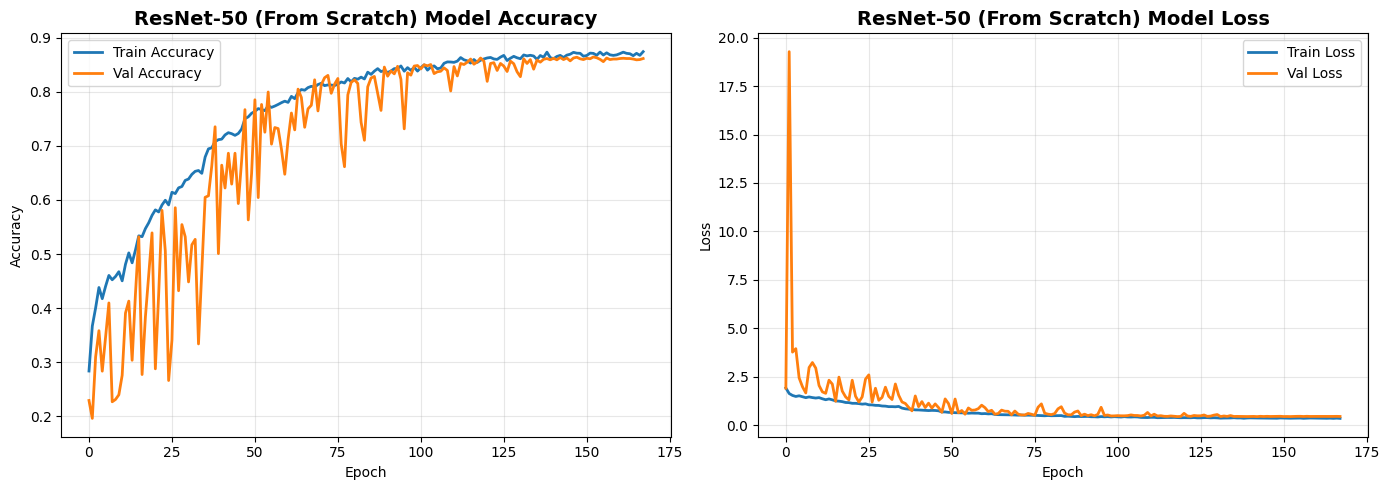


Generating confusion matrix...
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step


<Figure size 1200x1000 with 0 Axes>

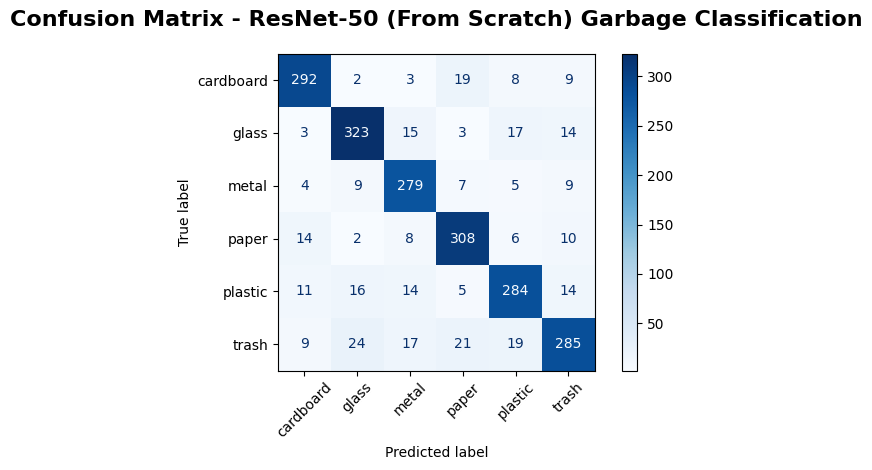


CLASSIFICATION REPORT - RESNET-50 (FROM SCRATCH)
              precision    recall  f1-score   support

   cardboard       0.88      0.88      0.88       333
       glass       0.86      0.86      0.86       375
       metal       0.83      0.89      0.86       313
       paper       0.85      0.89      0.87       348
     plastic       0.84      0.83      0.83       344
       trash       0.84      0.76      0.80       375

    accuracy                           0.85      2088
   macro avg       0.85      0.85      0.85      2088
weighted avg       0.85      0.85      0.85      2088


All outputs saved to: /kaggle/working/garbage_resnet50_scratch_run_20251130-055235


In [31]:
print("\nEvaluating on test set...")
test_loss, test_acc = model_resnet.evaluate(test_generator, steps=math.ceil(test_generator.samples / BATCH_SIZE))
print(f"\n📊 Test Accuracy: {test_acc*100:.2f}%")
print(f"📊 Test Loss: {test_loss:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_resnet.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_resnet.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('ResNet-50 (From Scratch) Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_resnet.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_resnet.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('ResNet-50 (From Scratch) Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(out_dir_resnet, 'training_history_resnet50_scratch.png'), dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix
print("\nGenerating confusion matrix...")
test_generator.reset()
y_pred = model_resnet.predict(test_generator, steps=math.ceil(test_generator.samples / BATCH_SIZE), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title('Confusion Matrix - ResNet-50 (From Scratch) Garbage Classification', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(out_dir_resnet, 'confusion_matrix_resnet50_scratch.png'), dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT - RESNET-50 (FROM SCRATCH)")
print("="*60)
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Save report
report_dict = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
with open(os.path.join(out_dir_resnet, 'classification_report_resnet50_scratch.json'), 'w') as f:
    json.dump(report_dict, f, indent=2)

print(f"\nAll outputs saved to: {out_dir_resnet}")




SO SÁNH MÔ HÌNH: CUSTOM CNN vs RESNET-50
Test trên cùng 1 tập dữ liệu
✅ Đã tìm thấy cả 2 mô hình

Đang tạo test generator...
Found 2088 images belonging to 6 classes.
✅ Test samples: 2088
✅ Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

TESTING CUSTOM CNN...
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9146 - loss: 0.2681
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step

📊 Custom CNN - Test Accuracy: 0.8961 (89.61%)
📊 Custom CNN - Test Loss: 0.3152

TESTING RESNET-50...
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8735 - loss: 0.4148
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step

📊 ResNet-50 - Test Accuracy: 0.8482 (84.82%)
📊 ResNet-50 - Test Loss: 0.4904

SO SÁNH KẾT QUẢ

📊 Bảng so sánh:
       Metric Custom CNN ResNet-50 Difference
Test Accuracy     0.8961    0.8482    -0.0479
    Test Loss     0.3152    0.4904    +0.1751

🏆 MÔ HÌNH TỐT NHẤT: Custom CNN
   Cải thiện: +4.79% so với ResNet-50

SO SÁNH PER-CLASS PERFORMANCE


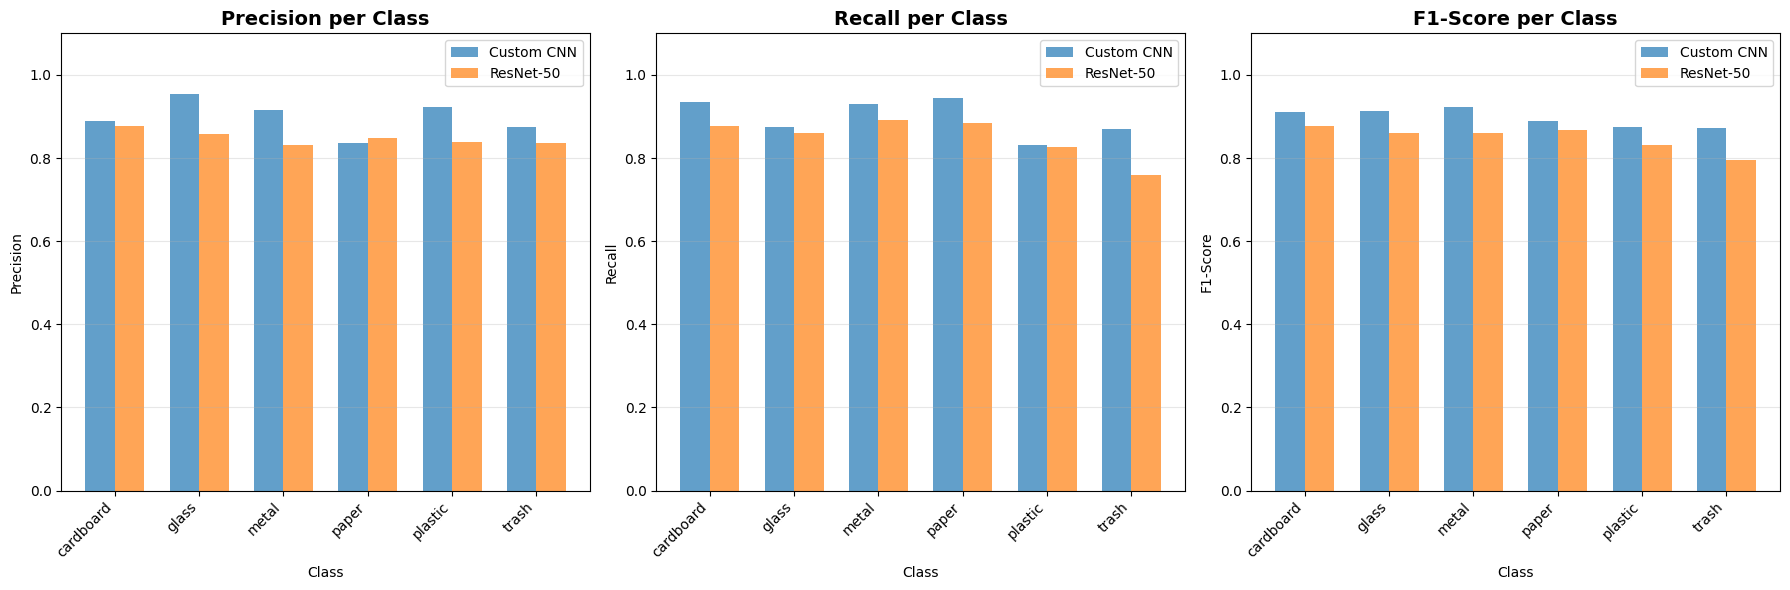


📊 Chi tiết theo từng class:
    Class CNN Precision ResNet Precision CNN Recall ResNet Recall CNN F1 ResNet F1
cardboard        0.8886           0.8769     0.9339        0.8769 0.9107    0.8769
    glass        0.9535           0.8590     0.8747        0.8613 0.9124    0.8602
    metal        0.9151           0.8304     0.9297        0.8914 0.9223    0.8598
    paper        0.8372           0.8485     0.9454        0.8851 0.8880    0.8664
  plastic        0.9226           0.8378     0.8314        0.8256 0.8746    0.8316
    trash        0.8740           0.8358     0.8693        0.7600 0.8717    0.7961

CONFUSION MATRIX COMPARISON


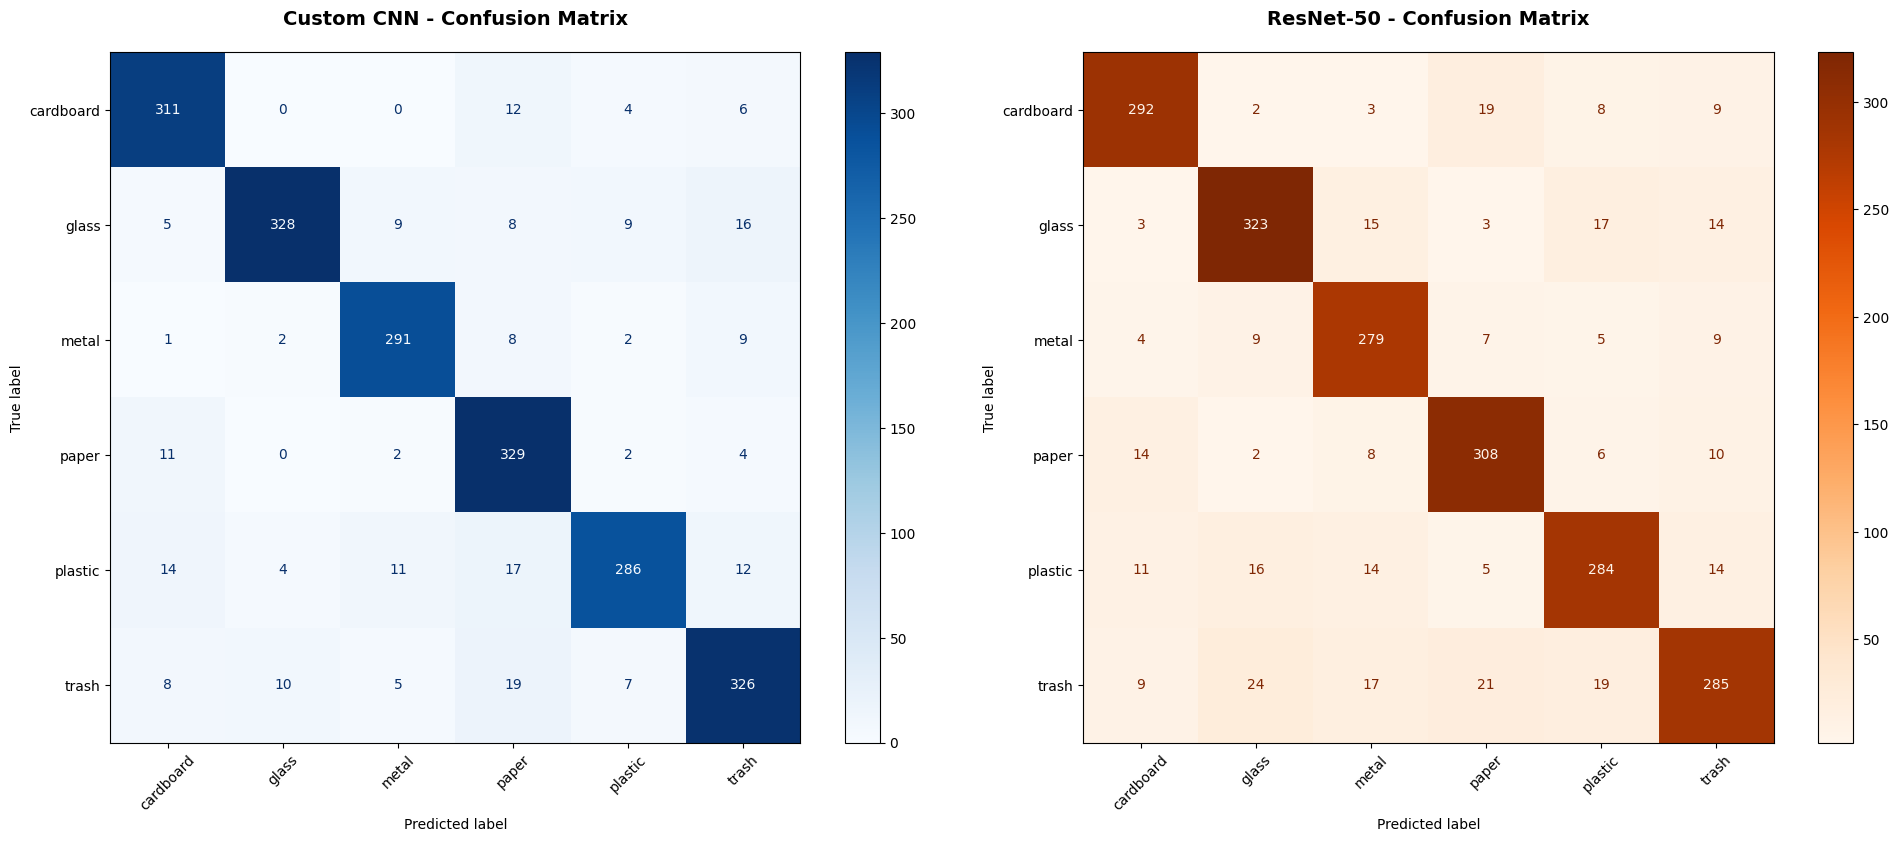


TÓM TẮT SO SÁNH

📈 Custom CNN:
   - Test Accuracy: 0.8961 (89.61%)
   - Test Loss: 0.3152

📈 ResNet-50:
   - Test Accuracy: 0.8482 (84.82%)
   - Test Loss: 0.4904

✅ Hoàn thành so sánh!


In [34]:
# ============================================================================
# SO SÁNH 2 MÔ HÌNH: TEST TRÊN CÙNG 1 TẬP TEST DATA
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

print("="*70)
print("SO SÁNH MÔ HÌNH: CUSTOM CNN vs RESNET-50")
print("Test trên cùng 1 tập dữ liệu")
print("="*70)

# Kiểm tra model có tồn tại không
try:
    _ = model
    _ = model_resnet
    print("✅ Đã tìm thấy cả 2 mô hình\n")
except NameError as e:
    print(f"⚠️  Lỗi: {e}")
    print("Vui lòng chạy cell 0 và cell 1 trước để train mô hình.\n")
    raise

# Tạo test generator chung cho cả 2 model
# Sử dụng test_dir từ cell 0 (hoặc có thể dùng từ cell 1)
print("Đang tạo test generator...")
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir, 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=False
)
test_class_labels = list(test_gen.class_indices.keys())
print(f"✅ Test samples: {test_gen.samples}")
print(f"✅ Classes: {test_class_labels}\n")

# ============================================================================
# 1. TEST CUSTOM CNN
# ============================================================================

print("="*70)
print("TESTING CUSTOM CNN...")
print("="*70)

test_gen.reset()
test_loss_cnn, test_acc_cnn = model.evaluate(
    test_gen, 
    steps=math.ceil(test_gen.samples / BATCH_SIZE), 
    verbose=1
)

test_gen.reset()
y_pred_cnn = model.predict(test_gen, steps=math.ceil(test_gen.samples / BATCH_SIZE), verbose=1)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true = test_gen.classes[:len(y_pred_classes_cnn)]

report_cnn = classification_report(y_true, y_pred_classes_cnn, target_names=test_class_labels, output_dict=True)

print(f"\n📊 Custom CNN - Test Accuracy: {test_acc_cnn:.4f} ({test_acc_cnn*100:.2f}%)")
print(f"📊 Custom CNN - Test Loss: {test_loss_cnn:.4f}\n")

# ============================================================================
# 2. TEST RESNET-50
# ============================================================================

print("="*70)
print("TESTING RESNET-50...")
print("="*70)

test_gen.reset()
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(
    test_gen,
    steps=math.ceil(test_gen.samples / BATCH_SIZE),
    verbose=1
)

test_gen.reset()
y_pred_resnet = model_resnet.predict(test_gen, steps=math.ceil(test_gen.samples / BATCH_SIZE), verbose=1)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)
# y_true đã có từ phần trên

report_resnet = classification_report(y_true, y_pred_classes_resnet, target_names=test_class_labels, output_dict=True)

print(f"\n📊 ResNet-50 - Test Accuracy: {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%)")
print(f"📊 ResNet-50 - Test Loss: {test_loss_resnet:.4f}\n")

# ============================================================================
# 3. SO SÁNH KẾT QUẢ
# ============================================================================

print("="*70)
print("SO SÁNH KẾT QUẢ")
print("="*70)

# Bảng so sánh
comparison_data = {
    'Metric': ['Test Accuracy', 'Test Loss'],
    'Custom CNN': [f"{test_acc_cnn:.4f}", f"{test_loss_cnn:.4f}"],
    'ResNet-50': [f"{test_acc_resnet:.4f}", f"{test_loss_resnet:.4f}"],
    'Difference': [
        f"{test_acc_resnet - test_acc_cnn:+.4f}",
        f"{test_loss_resnet - test_loss_cnn:+.4f}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n📊 Bảng so sánh:")
print(df_comparison.to_string(index=False))

# Xác định mô hình tốt nhất
print("\n" + "="*70)
if test_acc_resnet > test_acc_cnn:
    winner = "ResNet-50"
    improvement = (test_acc_resnet - test_acc_cnn) * 100
    print(f"🏆 MÔ HÌNH TỐT NHẤT: {winner}")
    print(f"   Cải thiện: +{improvement:.2f}% so với Custom CNN")
elif test_acc_cnn > test_acc_resnet:
    winner = "Custom CNN"
    improvement = (test_acc_cnn - test_acc_resnet) * 100
    print(f"🏆 MÔ HÌNH TỐT NHẤT: {winner}")
    print(f"   Cải thiện: +{improvement:.2f}% so với ResNet-50")
else:
    print("🤝 HAI MÔ HÌNH CÓ KẾT QUẢ TƯƠNG ĐƯƠNG")
print("="*70)

# ============================================================================
# 4. SO SÁNH PER-CLASS PERFORMANCE
# ============================================================================

print("\n" + "="*70)
print("SO SÁNH PER-CLASS PERFORMANCE")
print("="*70)

# Extract per-class metrics
class_names = [k for k in report_cnn.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]

precision_cnn = [report_cnn[cls]['precision'] for cls in class_names]
recall_cnn = [report_cnn[cls]['recall'] for cls in class_names]
f1_cnn = [report_cnn[cls]['f1-score'] for cls in class_names]

precision_resnet = [report_resnet[cls]['precision'] for cls in class_names]
recall_resnet = [report_resnet[cls]['recall'] for cls in class_names]
f1_resnet = [report_resnet[cls]['f1-score'] for cls in class_names]

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

x = np.arange(len(class_names))
width = 0.35

# Precision
axes[0].bar(x - width/2, precision_cnn, width, label='Custom CNN', color='#1f77b4', alpha=0.7)
axes[0].bar(x + width/2, precision_resnet, width, label='ResNet-50', color='#ff7f0e', alpha=0.7)
axes[0].set_title('Precision per Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Precision')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# Recall
axes[1].bar(x - width/2, recall_cnn, width, label='Custom CNN', color='#1f77b4', alpha=0.7)
axes[1].bar(x + width/2, recall_resnet, width, label='ResNet-50', color='#ff7f0e', alpha=0.7)
axes[1].set_title('Recall per Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.1])

# F1-Score
axes[2].bar(x - width/2, f1_cnn, width, label='Custom CNN', color='#1f77b4', alpha=0.7)
axes[2].bar(x + width/2, f1_resnet, width, label='ResNet-50', color='#ff7f0e', alpha=0.7)
axes[2].set_title('F1-Score per Class', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('F1-Score')
axes[2].set_xticks(x)
axes[2].set_xticklabels(class_names, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# Create detailed per-class table
per_class_data = {
    'Class': class_names,
    'CNN Precision': [f"{p:.4f}" for p in precision_cnn],
    'ResNet Precision': [f"{p:.4f}" for p in precision_resnet],
    'CNN Recall': [f"{r:.4f}" for r in recall_cnn],
    'ResNet Recall': [f"{r:.4f}" for r in recall_resnet],
    'CNN F1': [f"{f:.4f}" for f in f1_cnn],
    'ResNet F1': [f"{f:.4f}" for f in f1_resnet],
}

df_per_class = pd.DataFrame(per_class_data)
print("\n📊 Chi tiết theo từng class:")
print(df_per_class.to_string(index=False))

# ============================================================================
# 5. CONFUSION MATRIX COMPARISON
# ============================================================================

print("\n" + "="*70)
print("CONFUSION MATRIX COMPARISON")
print("="*70)

cm_cnn = confusion_matrix(y_true, y_pred_classes_cnn)
cm_resnet = confusion_matrix(y_true, y_pred_classes_resnet)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Custom CNN Confusion Matrix
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=test_class_labels)
disp_cnn.plot(ax=axes[0], cmap='Blues', xticks_rotation=45, values_format='d')
axes[0].set_title('Custom CNN - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

# ResNet-50 Confusion Matrix
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=test_class_labels)
disp_resnet.plot(ax=axes[1], cmap='Oranges', xticks_rotation=45, values_format='d')
axes[1].set_title('ResNet-50 - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. SUMMARY
# ============================================================================

print("\n" + "="*70)
print("TÓM TẮT SO SÁNH")
print("="*70)
print(f"\n📈 Custom CNN:")
print(f"   - Test Accuracy: {test_acc_cnn:.4f} ({test_acc_cnn*100:.2f}%)")
print(f"   - Test Loss: {test_loss_cnn:.4f}")

print(f"\n📈 ResNet-50:")
print(f"   - Test Accuracy: {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%)")
print(f"   - Test Loss: {test_loss_resnet:.4f}")

print("\n" + "="*70)
print("✅ Hoàn thành so sánh!")
print("="*70)

